# Fine-tuning con LoRA de Ministral3-8B

## Importar librerías

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from transformers import (
    Mistral3ForConditionalGeneration,
    FineGrainedFP8Config,
    MistralCommonBackend,
    get_cosine_schedule_with_warmup,
)
from peft import LoraConfig, get_peft_model, TaskType

ImportError: cannot import name 'MistralCommonBackend' from 'transformers' (/home/alumno.upv.es/scheng1/.conda/envs/RFA2526pt/lib/python3.12/site-packages/transformers/__init__.py)

## Configuración y parámetros

In [ ]:
os.environ["HF_TOKEN"] = "tu_tokens"

MODEL_NAME  = "mistralai/Ministral-3-8B-Instruct-2512"
MAIN_PATH   = ".."
GROUP_ID    = "BeingChillingWeWillWin"

TEXT_COLUMN  = "tweet"
LABEL_COLUMN = "task1"

DATA_TRAIN_PATH = os.path.join(MAIN_PATH, "preprocessed_data", "train_preprocessed_v2.json")
DATA_VAL_PATH   = os.path.join(MAIN_PATH, "preprocessed_data", "val_preprocessed_v2.json")
DATA_TEST_PATH  = os.path.join(MAIN_PATH, "preprocessed_data", "test_preprocessed_v2.json")

OUTPUT_DIR      = os.path.join(MAIN_PATH, "results_v2", "3Ministral8B_LoRA")
SAVE_PATH       = os.path.join(MAIN_PATH, "results_v2", "3Ministral8B_LoRA", "lora_weights")
PREDICTIONS_DIR = os.path.join(MAIN_PATH, "results_v2", "3Ministral8B_LoRA", "predictions")

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(SAVE_PATH, exist_ok=True)
os.makedirs(PREDICTIONS_DIR, exist_ok=True)

# ── Hiperparámetros ──
TRAIN_BATCH_SIZE = 4      # batch para entrenamiento (gradient accumulation compensa el tamaño pequeño)
GRAD_ACCUM_STEPS = 8      # pasos de acumulación → batch efectivo = 4 * 8 = 32
INFER_BATCH_SIZE = 16     # batch para inferencia
MAX_INPUT_LEN    = 256    # tokens máximos del prompt
MAX_NEW_TOKENS   = 5      # tokens máximos a generar (YES / NO)
NUM_EPOCHS       = 3
LEARNING_RATE    = 2e-4

## Carga y preprocesamiento de datos

In [3]:
train_df = pd.read_json(DATA_TRAIN_PATH)
val_df   = pd.read_json(DATA_VAL_PATH)
test_df  = pd.read_json(DATA_TEST_PATH)

label_map         = {"NO": 0, "YES": 1}
label_map_inverse = {0: "NO", 1: "YES"}

train_df["label"] = train_df[LABEL_COLUMN].map(label_map)
val_df["label"]   = val_df[LABEL_COLUMN].map(label_map)

print(f"Text column used : {TEXT_COLUMN}")
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print("\nDistribución TRAIN:")
print(train_df[LABEL_COLUMN].value_counts())
print("\nDistribución VAL:")
print(val_df[LABEL_COLUMN].value_counts())

Text column used : tweet
Train: 5154 | Val: 910 | Test: 934

Distribución TRAIN:
task1
NO     2862
YES    2292
Name: count, dtype: int64

Distribución VAL:
task1
NO     505
YES    405
Name: count, dtype: int64


## Carga del modelo y tokenizer

In [4]:
tokenizer = MistralCommonBackend.from_pretrained(MODEL_NAME)
tokenizer.pad_token    = tokenizer.eos_token
tokenizer.padding_side = "left"

model = Mistral3ForConditionalGeneration.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    quantization_config=FineGrainedFP8Config(dequantize=True),
)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,   # LLM generativo, no SEQ_CLS
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/531 [00:00<?, ?it/s]

trainable params: 8,814,592 || all params: 8,926,840,832 || trainable%: 0.0987


## Definición del prompt

Usamos un prompt de instrucción con formato chat. Para el fine-tuning, añadimos la respuesta esperada al final para que el modelo aprenda a generarla.

In [5]:
SYSTEM_PROMPT = (
    "You are a text classification assistant. "
    "Your task is to determine whether the following text contains sexism. "
    "Answer with exactly one word: YES or NO."
)

def build_messages(text: str) -> list:
    """Mensajes de chat para inferencia (sin respuesta)."""
    return [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user",   "content": f"Text: {text}\n\nDoes this text contain sexism?"},
    ]

def build_training_prompt(text: str, label_str: str) -> str:
    """Prompt completo para entrenamiento: incluye la respuesta esperada al final."""
    messages = build_messages(text)
    # Aplicamos la plantilla de chat y añadimos la etiqueta como respuesta del asistente
    base = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return base + label_str + tokenizer.eos_token

## Dataset de PyTorch para fine-tuning

In [6]:
class SexismDataset(Dataset):
    def __init__(self, df, text_col, label_col_str, tokenizer, max_length):
        self.samples = []
        for _, row in df.iterrows():
            label_str = row[label_col_str]   # "YES" o "NO"
            full_text = build_training_prompt(row[text_col], label_str)
            self.samples.append(full_text)
        self.tokenizer  = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


def collate_fn(batch_texts):
    """Tokeniza el batch, construye labels enmascarando el prompt."""
    encoding = tokenizer(
        batch_texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_INPUT_LEN,
    )
    input_ids      = encoding["input_ids"]
    attention_mask = encoding["attention_mask"]

    # Labels: copiar input_ids y enmascarar padding con -100
    labels = input_ids.clone()
    labels[labels == tokenizer.pad_token_id] = -100

    return {
        "input_ids":      input_ids,
        "attention_mask": attention_mask,
        "labels":         labels,
    }


train_dataset = SexismDataset(train_df, TEXT_COLUMN, LABEL_COLUMN, tokenizer, MAX_INPUT_LEN)
val_dataset   = SexismDataset(val_df,   TEXT_COLUMN, LABEL_COLUMN, tokenizer, MAX_INPUT_LEN)

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=TRAIN_BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Batches de entrenamiento : {len(train_loader)}")
print(f"Batches de validación    : {len(val_loader)}")

`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


`MistralCommonBackend.apply_chat_template(..., tokenize=False)` is unsafe and may lead to unexpected behavior. Please consider using `tokenize=True` instead and don't encode the output manually.


Batches de entrenamiento : 1289
Batches de validación    : 228


## Entrenamiento con LoRA

Epoch 1/3 | Train Loss: 1.8032 | Val Loss: 1.6182


  ✓ Mejor modelo guardado (val_loss=1.6182)


Epoch 2/3 | Train Loss: 1.5870 | Val Loss: 1.6135


  ✓ Mejor modelo guardado (val_loss=1.6135)


Epoch 3/3 | Train Loss: 1.5459 | Val Loss: 1.6165


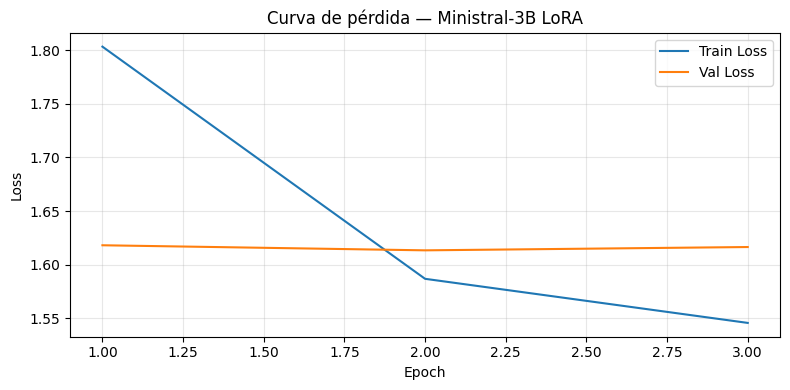

In [7]:
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=0.01,
)

total_steps   = (len(train_loader) // GRAD_ACCUM_STEPS) * NUM_EPOCHS
warmup_steps  = total_steps // 10

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)

train_losses = []
val_losses   = []
best_val_loss = float("inf")

for epoch in range(1, NUM_EPOCHS + 1):
    # ── TRAIN ──
    model.train()
    epoch_loss    = 0.0
    optimizer.zero_grad()

    for step, batch in enumerate(train_loader, start=1):
        batch = {k: v.to("cuda") for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss / GRAD_ACCUM_STEPS
        loss.backward()
        epoch_loss += outputs.loss.item()

        if step % GRAD_ACCUM_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ── VALIDATION ──
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to("cuda") for k, v in batch.items()}
            val_loss += model(**batch).loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch}/{NUM_EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Guardar el mejor modelo
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model.save_pretrained(SAVE_PATH)
        tokenizer.save_pretrained(SAVE_PATH)
        print(f"  ✓ Mejor modelo guardado (val_loss={best_val_loss:.4f})")

# Curva de pérdida
plt.figure(figsize=(8, 4))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, NUM_EPOCHS + 1), val_losses,   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Curva de pérdida — Ministral-3B LoRA")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()